# Machine Learning Trading Bot

This script  combines algorithmic trading with financial Python programming and machine learning to create an algorithmic trading bot that learns and adapts to new data and evolving markets.

## Instructions:

 The script is divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.svm import SVC

---
## Establish a Baseline Performance


In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

open   high    low  close  volume
date                                                   
2015-01-21 09:30:00  23.83  23.83  23.83  23.83     100
2015-01-21 11:00:00  23.98  23.98  23.98  23.98     100
2015-01-22 15:00:00  24.42  24.42  24.42  24.42     100
2015-01-22 15:15:00  24.42  24.44  24.42  24.44     200
2015-01-22 15:30:00  24.46  24.46  24.46  24.46     200

In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

close  Actual Returns
date                                      
2015-01-21 11:00:00  23.98        0.006295
2015-01-22 15:00:00  24.42        0.018349
2015-01-22 15:15:00  24.44        0.000819
2015-01-22 15:30:00  24.46        0.000818
2015-01-26 12:30:00  24.33       -0.005315

close  Actual Returns
date                                      
2021-01-22 09:30:00  33.27       -0.006866
2021-01-22 11:30:00  33.35        0.002405
2021-01-22 13:45:00  33.42        0.002099
2021-01-22 14:30:00  33.47        0.001496
2021-01-22 15:45:00  33.44       -0.000896

In [4]:
# Generate trading signals using short- and long-window SMA values. 
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

close  Actual Returns  SMA_Fast  SMA_Slow
date                                                          
2015-04-02 14:45:00  24.92        0.000000   24.9175   24.3214
2015-04-02 15:00:00  24.92        0.000000   24.9200   24.3308
2015-04-02 15:15:00  24.94        0.000803   24.9250   24.3360
2015-04-02 15:30:00  24.95        0.000401   24.9325   24.3411
2015-04-02 15:45:00  24.98        0.001202   24.9475   24.3463

close  Actual Returns  SMA_Fast  SMA_Slow
date                                                          
2021-01-22 09:30:00  33.27       -0.006866   33.2025  30.40215
2021-01-22 11:30:00  33.35        0.002405   33.2725  30.44445
2021-01-22 13:45:00  33.42        0.002099   33.3850  30.48745
2021-01-22 14:30:00  33.47        0.001496   33.3775  30.53085
2021-01-22 15:45:00  33.44       -0.000896   33.4200  30.57495

In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

close  Actual Returns  SMA_Fast  SMA_Slow  Signal
date                                                                  
2015-04-02 14:45:00  24.92        0.000000   24.9175   24.3214     1.0
2015-04-02 15:00:00  24.92        0.000000   24.9200   24.3308     1.0
2015-04-02 15:15:00  24.94        0.000803   24.9250   24.3360     1.0
2015-04-02 15:30:00  24.95        0.000401   24.9325   24.3411     1.0
2015-04-02 15:45:00  24.98        0.001202   24.9475   24.3463     1.0

close  Actual Returns  SMA_Fast  SMA_Slow  Signal
date                                                                  
2021-01-22 09:30:00  33.27       -0.006866   33.2025  30.40215    -1.0
2021-01-22 11:30:00  33.35        0.002405   33.2725  30.44445     1.0
2021-01-22 13:45:00  33.42        0.002099   33.3850  30.48745     1.0
2021-01-22 14:30:00  33.47        0.001496   33.3775  30.53085     1.0
2021-01-22 15:45:00  33.44       -0.000896   33.4200  30.57495    -1.0

In [6]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * (signals_df['Signal'].shift())

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

close  Actual Returns  SMA_Fast  SMA_Slow  Signal  \
date                                                                     
2015-04-02 14:45:00  24.92        0.000000   24.9175   24.3214     1.0   
2015-04-02 15:00:00  24.92        0.000000   24.9200   24.3308     1.0   
2015-04-02 15:15:00  24.94        0.000803   24.9250   24.3360     1.0   
2015-04-02 15:30:00  24.95        0.000401   24.9325   24.3411     1.0   
2015-04-02 15:45:00  24.98        0.001202   24.9475   24.3463     1.0   

                     Strategy Returns  
date                                   
2015-04-02 14:45:00               NaN  
2015-04-02 15:00:00          0.000000  
2015-04-02 15:15:00          0.000803  
2015-04-02 15:30:00          0.000401  
2015-04-02 15:45:00          0.001202

close  Actual Returns  SMA_Fast  SMA_Slow  Signal  \
date                                                                     
2021-01-22 09:30:00  33.27       -0.006866   33.2025  30.40215    -1.0   
2021-01-22 11:30:00  33.35        0.002405   33.2725  30.44445     1.0   
2021-01-22 13:45:00  33.42        0.002099   33.3850  30.48745     1.0   
2021-01-22 14:30:00  33.47        0.001496   33.3775  30.53085     1.0   
2021-01-22 15:45:00  33.44       -0.000896   33.4200  30.57495    -1.0   

                     Strategy Returns  
date                                   
2021-01-22 09:30:00         -0.006866  
2021-01-22 11:30:00         -0.002405  
2021-01-22 13:45:00          0.002099  
2021-01-22 14:30:00          0.001496  
2021-01-22 15:45:00         -0.000896

<AxesSubplot:xlabel='date'>

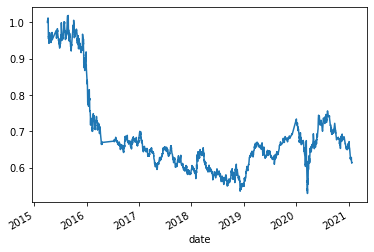

In [8]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [9]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

SMA_Fast  SMA_Slow
date                                   
2015-04-02 15:00:00   24.9175   24.3214
2015-04-02 15:15:00   24.9200   24.3308
2015-04-02 15:30:00   24.9250   24.3360
2015-04-02 15:45:00   24.9325   24.3411
2015-04-06 09:30:00   24.9475   24.3463

In [10]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [11]:
# Split the data into training and testing datasets.
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [12]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [13]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

SMA_Fast  SMA_Slow
date                                   
2015-06-30 12:15:00   24.2150   25.2106
2015-06-30 14:00:00   24.1050   25.1930
2015-06-30 14:15:00   24.0775   25.1767
2015-06-30 15:00:00   24.1000   25.1597
2015-07-02 10:45:00   24.1175   25.1427

In [14]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

SMA_Fast  SMA_Slow
date                                   
2015-07-06 10:00:00   24.1250   25.0919
2015-07-06 10:45:00   23.9700   25.0682
2015-07-06 14:15:00   23.8475   25.0458
2015-07-06 14:30:00   23.6725   25.0206
2015-07-07 11:30:00   23.4800   24.9951

In [15]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# From SVM, instantiate SVC classifier model instance
svm_model = SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled) 

# Review the model's predicted values
svm_pred


array([1., 1., 1., ..., 1., 1., 1.])

In [17]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



In [18]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

Predicted  Actual Returns  Strategy Returns
date                                                            
2015-07-06 10:00:00        1.0       -0.025715         -0.025715
2015-07-06 10:45:00        1.0        0.007237          0.007237
2015-07-06 14:15:00        1.0       -0.009721         -0.009721
2015-07-06 14:30:00        1.0       -0.003841         -0.003841
2015-07-07 11:30:00        1.0       -0.018423         -0.018423

Predicted  Actual Returns  Strategy Returns
date                                                            
2021-01-22 09:30:00        1.0       -0.006866         -0.006866
2021-01-22 11:30:00        1.0        0.002405          0.002405
2021-01-22 13:45:00        1.0        0.002099          0.002099
2021-01-22 14:30:00        1.0        0.001496          0.001496
2021-01-22 15:45:00        1.0       -0.000896         -0.000896

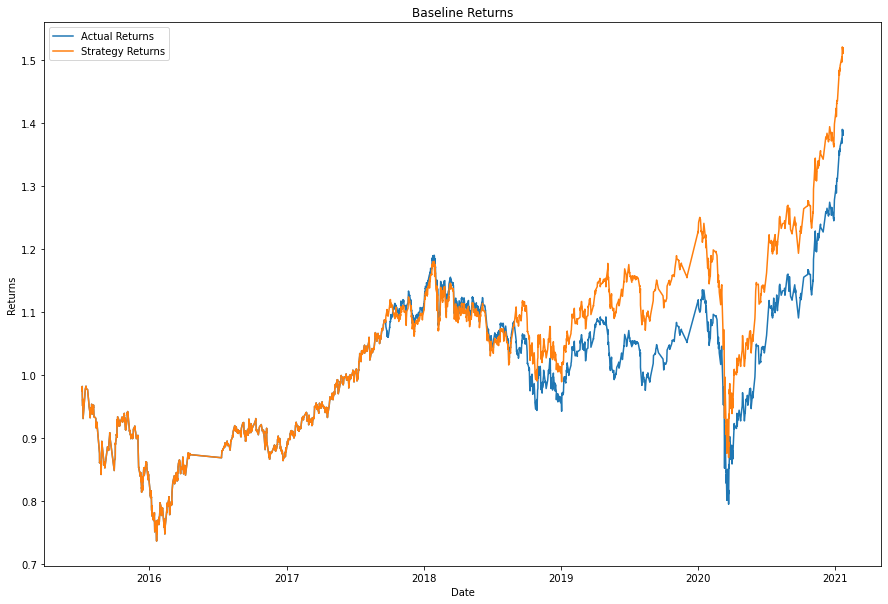

In [19]:
# Plot the actual returns versus the strategy returns
figure = plt.figure(figsize = (15,10))
plt.plot((1+predictions_df[['Actual Returns']]).cumprod(), label = 'Actual Returns')
plt.plot((1+predictions_df[['Strategy Returns']]).cumprod(), label = 'Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Baseline Returns')
plt.legend()
figure.savefig('./Images/baseline_returns.png')
plt.show()

---

## Tune the Baseline Trading Algorithm

### Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results. 

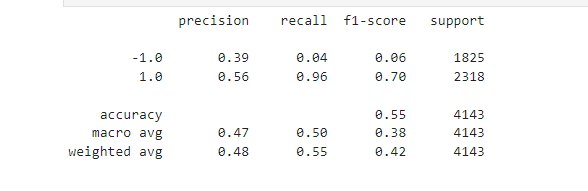
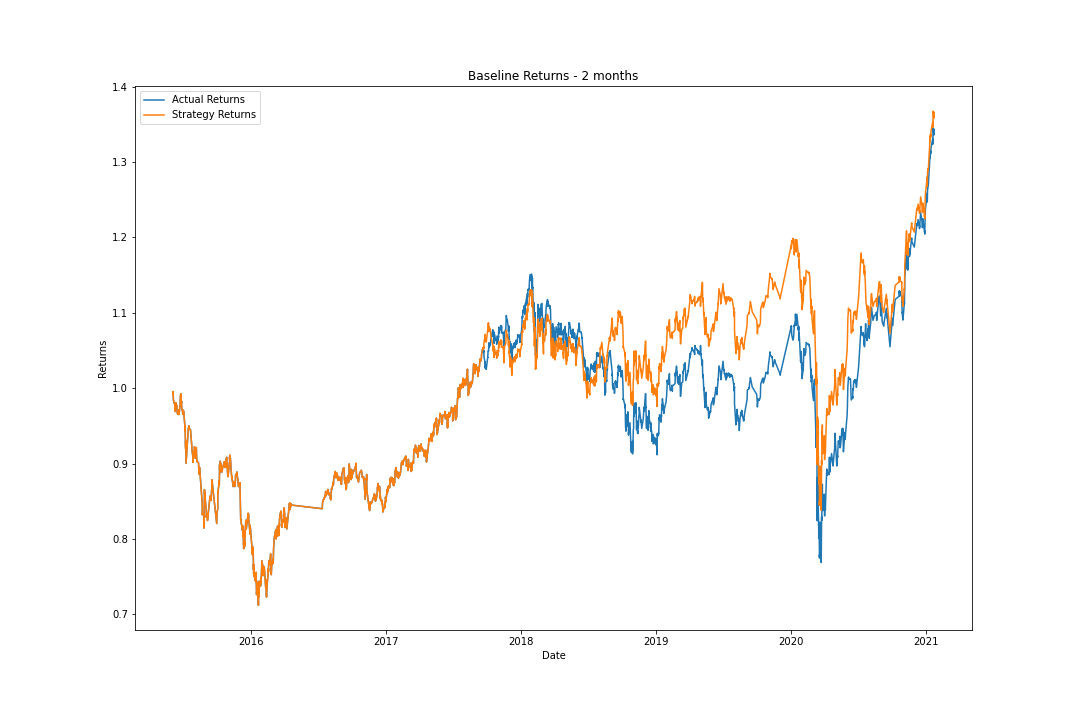
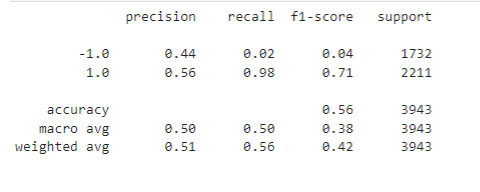
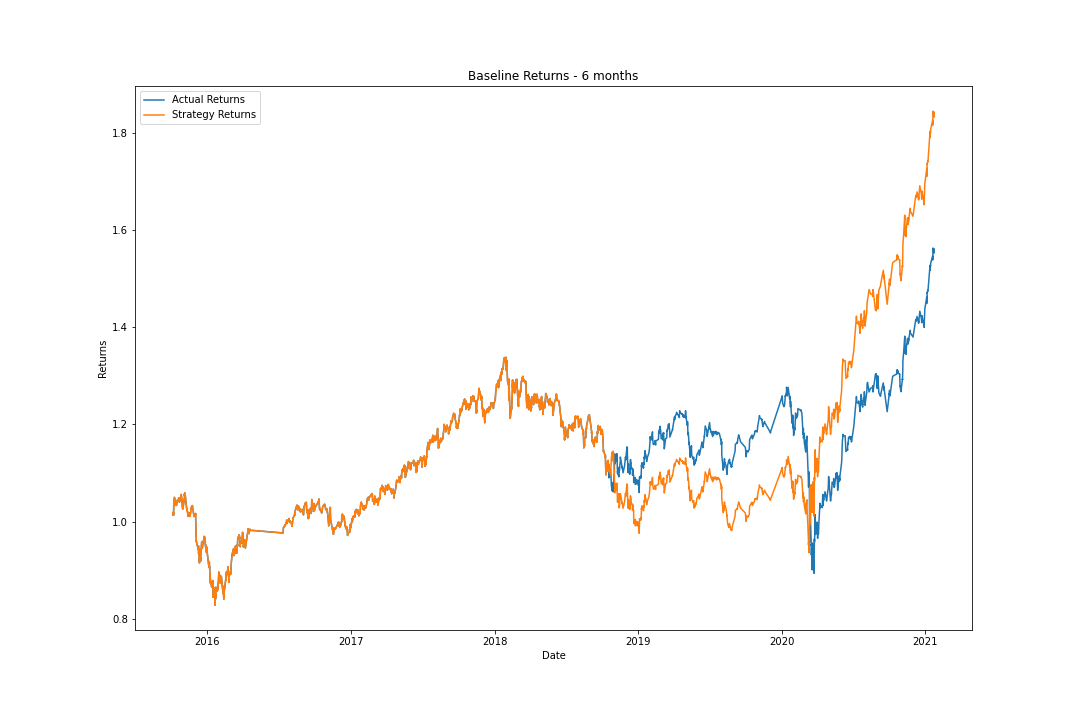

Answer the following question: What impact resulted from increasing or decreasing the training window?

Decreasing the training window  to 2 months did not have any significant impact on the results. The accuaracy remained at 55% and the recall values did not change. The precision value however for a sell position reduced from 43% to 39%

Increasing the training window to 6 months did increase the accuaracy by 1% to 56%. The recall value for a buy position increases by 2% and for the sell position decreases by 2%!The precision value for a buy position remains the same however it increases by 1% for the sell position. 

Overall we see a improvement in the predictivve analysis when we increase the training window. 

### Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results. 

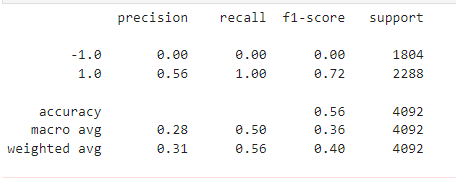
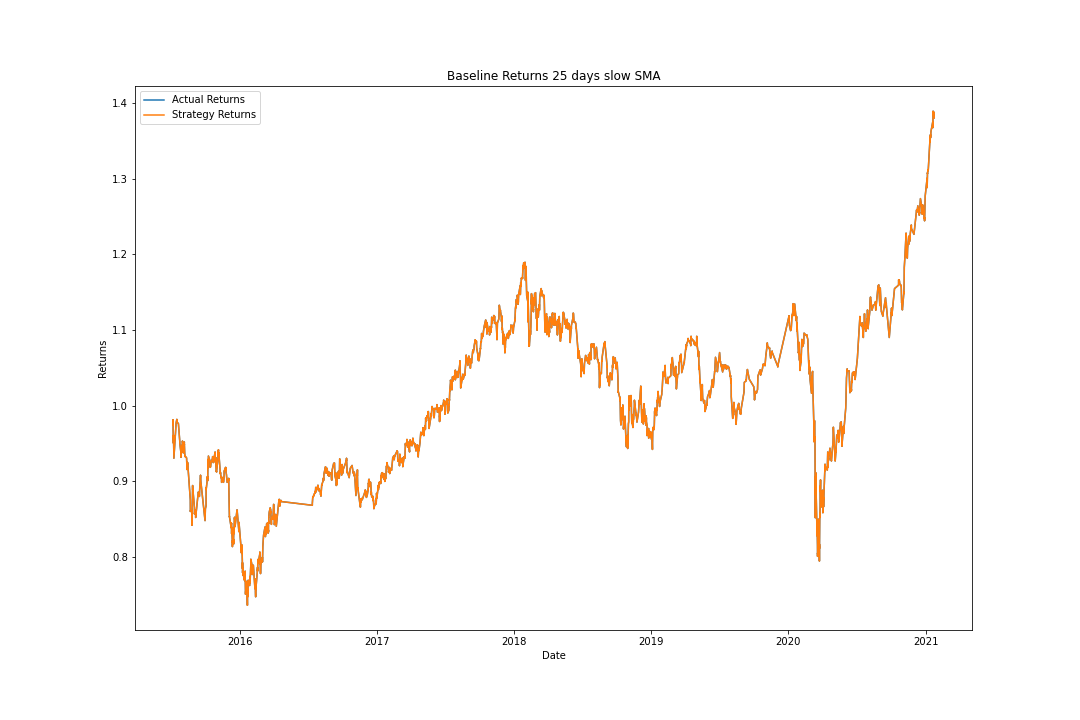
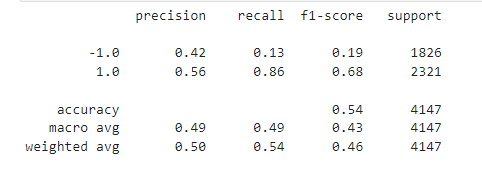
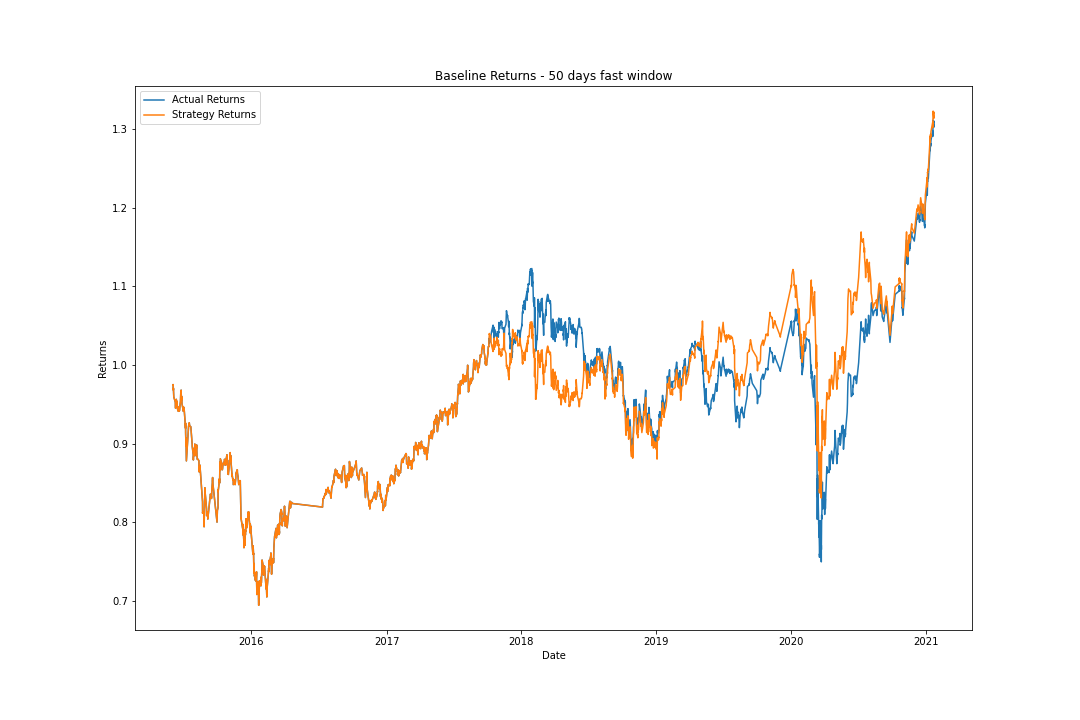
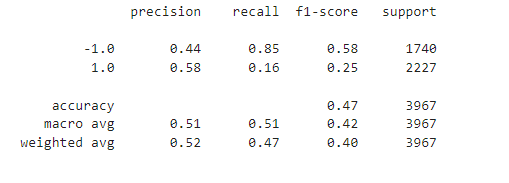
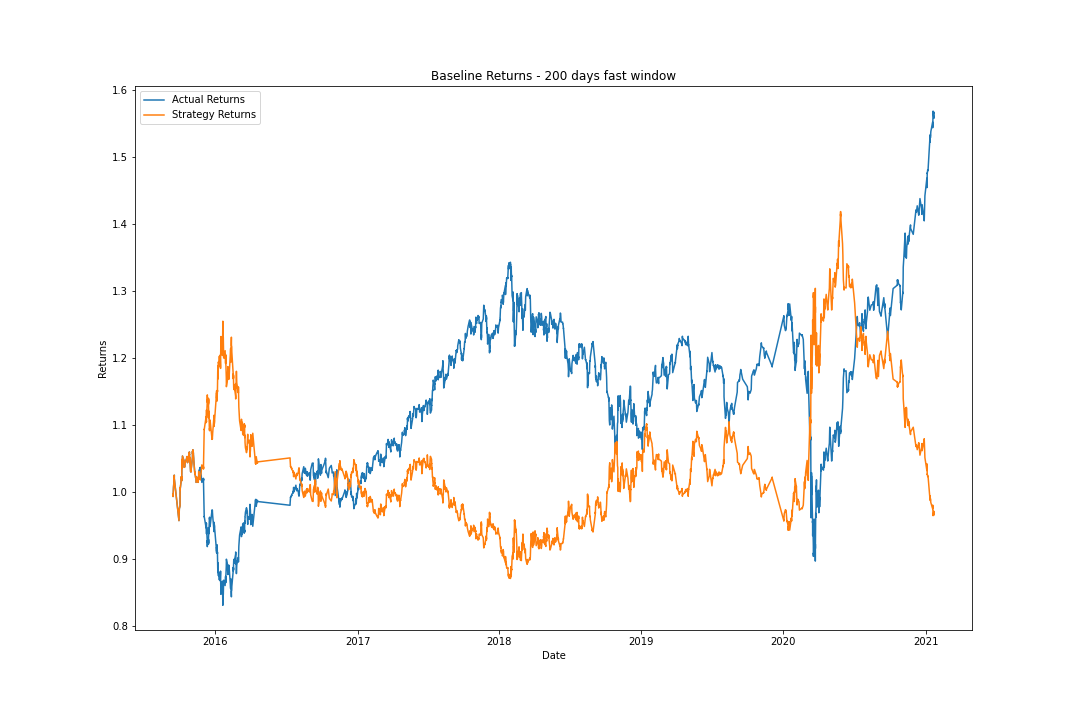

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

Increasing the Slow SMA window to 25, increases the accuracy to 56%, but it completely eliminates detecting the sell signal, which is not desirable.

Decreasing the Fast SMA window to 50, reduces the accuracy by 1%. It also reduces the recall value of the buy position from 96% to 86%

Increasing the Fast SMA window to 200, further reduces the accuracy to 47%. We also see a significant reduction in the recall value for our buy position from 96% to 16%.
We can hereby say that the best possible value for the Fast SMA window is 100. 

### Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion.

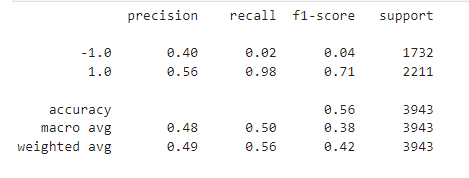
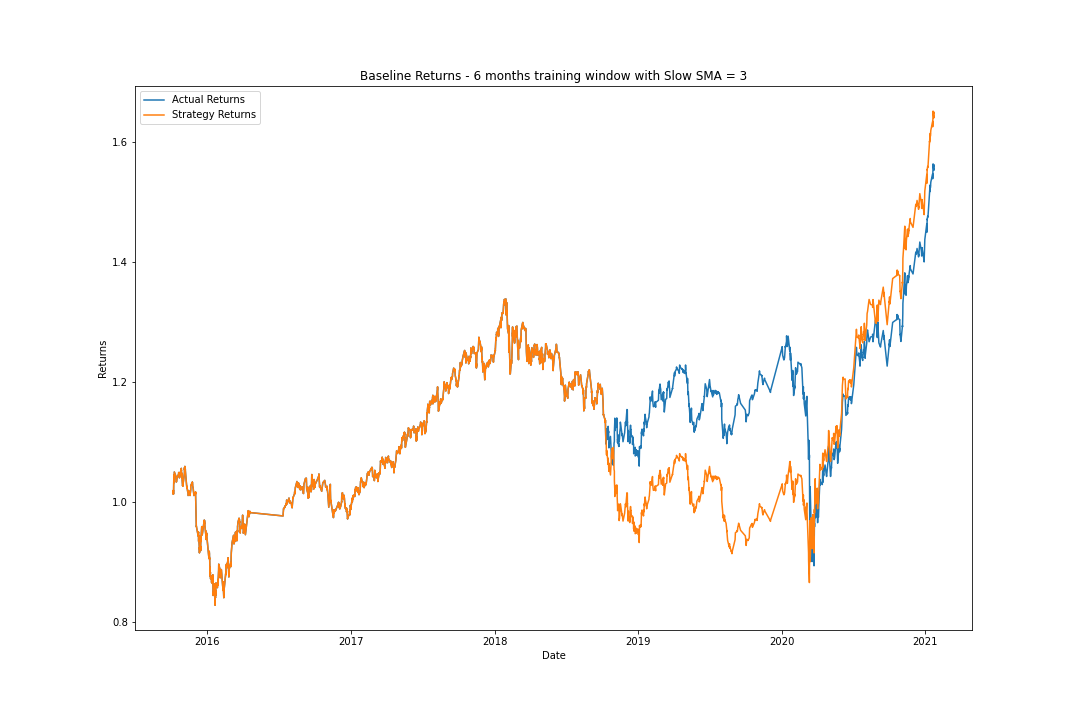

---

## Evaluate a New Machine Learning Classifier


In [20]:
# Import a new classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
ada = AdaBoostClassifier()


In [21]:
# Fit the model using the training data
model = ada.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = ada.predict(X_test_scaled)

# Review the model's predicted values
pred


array([ 1., -1., -1., ...,  1.,  1.,  1.])

In [22]:
# Use a classification report to evaluate the model using the predictions and testing data
ada_report = classification_report(y_test, pred)

# Print the classification report
print(ada_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.08      0.13      1804
         1.0       0.56      0.92      0.70      2288

    accuracy                           0.55      4092
   macro avg       0.50      0.50      0.41      4092
weighted avg       0.51      0.55      0.45      4092



In [23]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_ada_df = pd.DataFrame(index = X_test.index)

# Add the model predictions to the DataFrame
predictions_ada_df['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_ada_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_ada_df['Strategy Returns'] = signals_df['Actual Returns'] * predictions_ada_df['Predicted']

# Review the DataFrame
display(predictions_ada_df.head())
display(predictions_ada_df.tail())


Predicted  Actual Returns  Strategy Returns
date                                                            
2015-07-06 10:00:00        1.0       -0.025715         -0.025715
2015-07-06 10:45:00       -1.0        0.007237         -0.007237
2015-07-06 14:15:00       -1.0       -0.009721          0.009721
2015-07-06 14:30:00       -1.0       -0.003841          0.003841
2015-07-07 11:30:00       -1.0       -0.018423          0.018423

Predicted  Actual Returns  Strategy Returns
date                                                            
2021-01-22 09:30:00        1.0       -0.006866         -0.006866
2021-01-22 11:30:00        1.0        0.002405          0.002405
2021-01-22 13:45:00        1.0        0.002099          0.002099
2021-01-22 14:30:00        1.0        0.001496          0.001496
2021-01-22 15:45:00        1.0       -0.000896         -0.000896

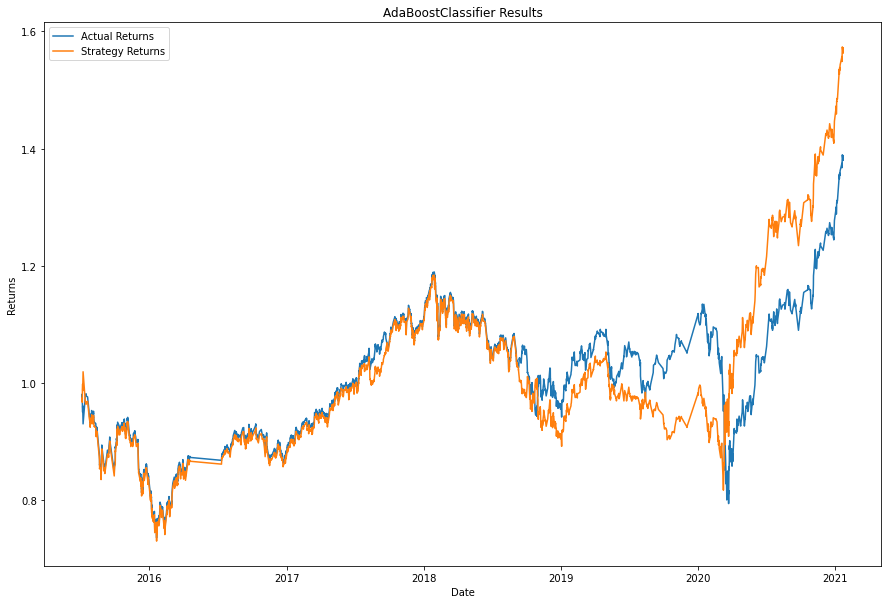

In [24]:
# Plot the actual returns versus the strategy returns
figure2 = plt.figure(figsize = (15,10))
plt.plot((1+predictions_ada_df[['Actual Returns']]).cumprod(), label = 'Actual Returns')
plt.plot((1+predictions_ada_df[['Strategy Returns']]).cumprod(), label = 'Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('AdaBoostClassifier Results')
plt.legend()
figure2.savefig('./Images/ada_returns.png')
plt.show()

Answer the following questions: 

Did this new model perform better or worse than the provided baseline model? 
The ada model performed similar to the baselime model with the same accuracy. The recall value for the buy position dropped to 92%
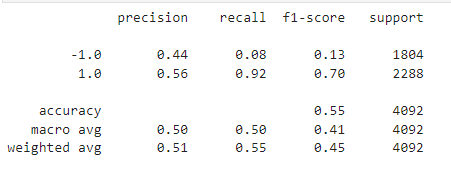
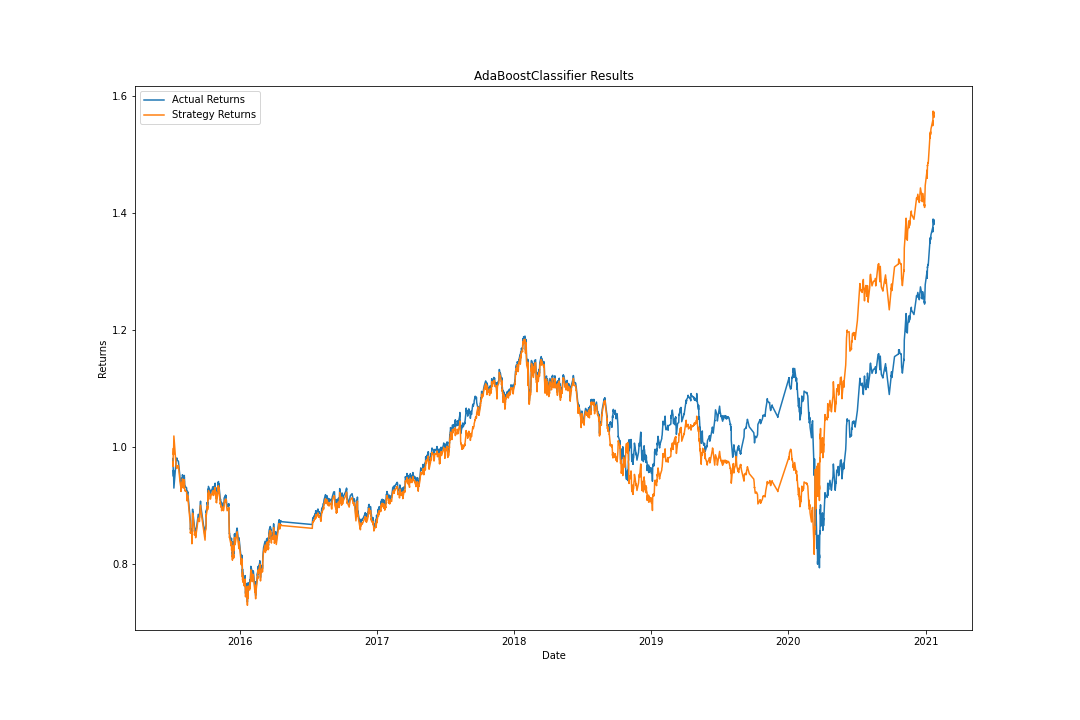

Did this new model perform better or worse than your tuned trading algorithm?
The ADABoost model performed worse than the tuned trading algorithm. The accuracy was reduced to 50%. The recall values are well balanced with this model. 
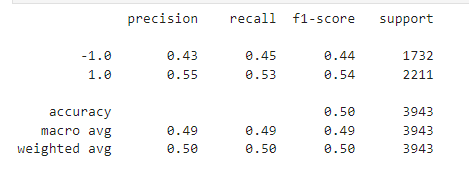
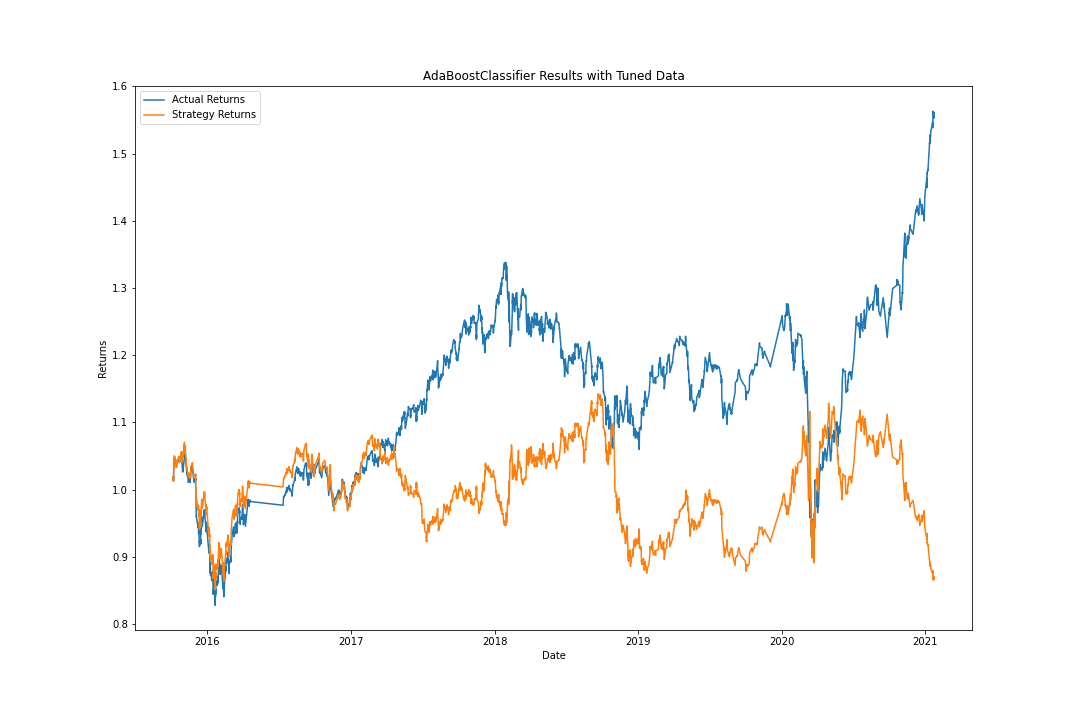